In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
# 타겟 피쳐 y로 저장 앤 제거
y = data['price']
del data['price']

# train, test 데이터 합치기
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [5]:
# 데이터 결측치 확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [6]:
# test id 저장, id 컬럼 제거
sub_id = data['id'][train_len:]
del data['id']

In [7]:
# 날짜 데이터 string화
data['date'] = data['date'].apply(lambda x : str(x[:6]))

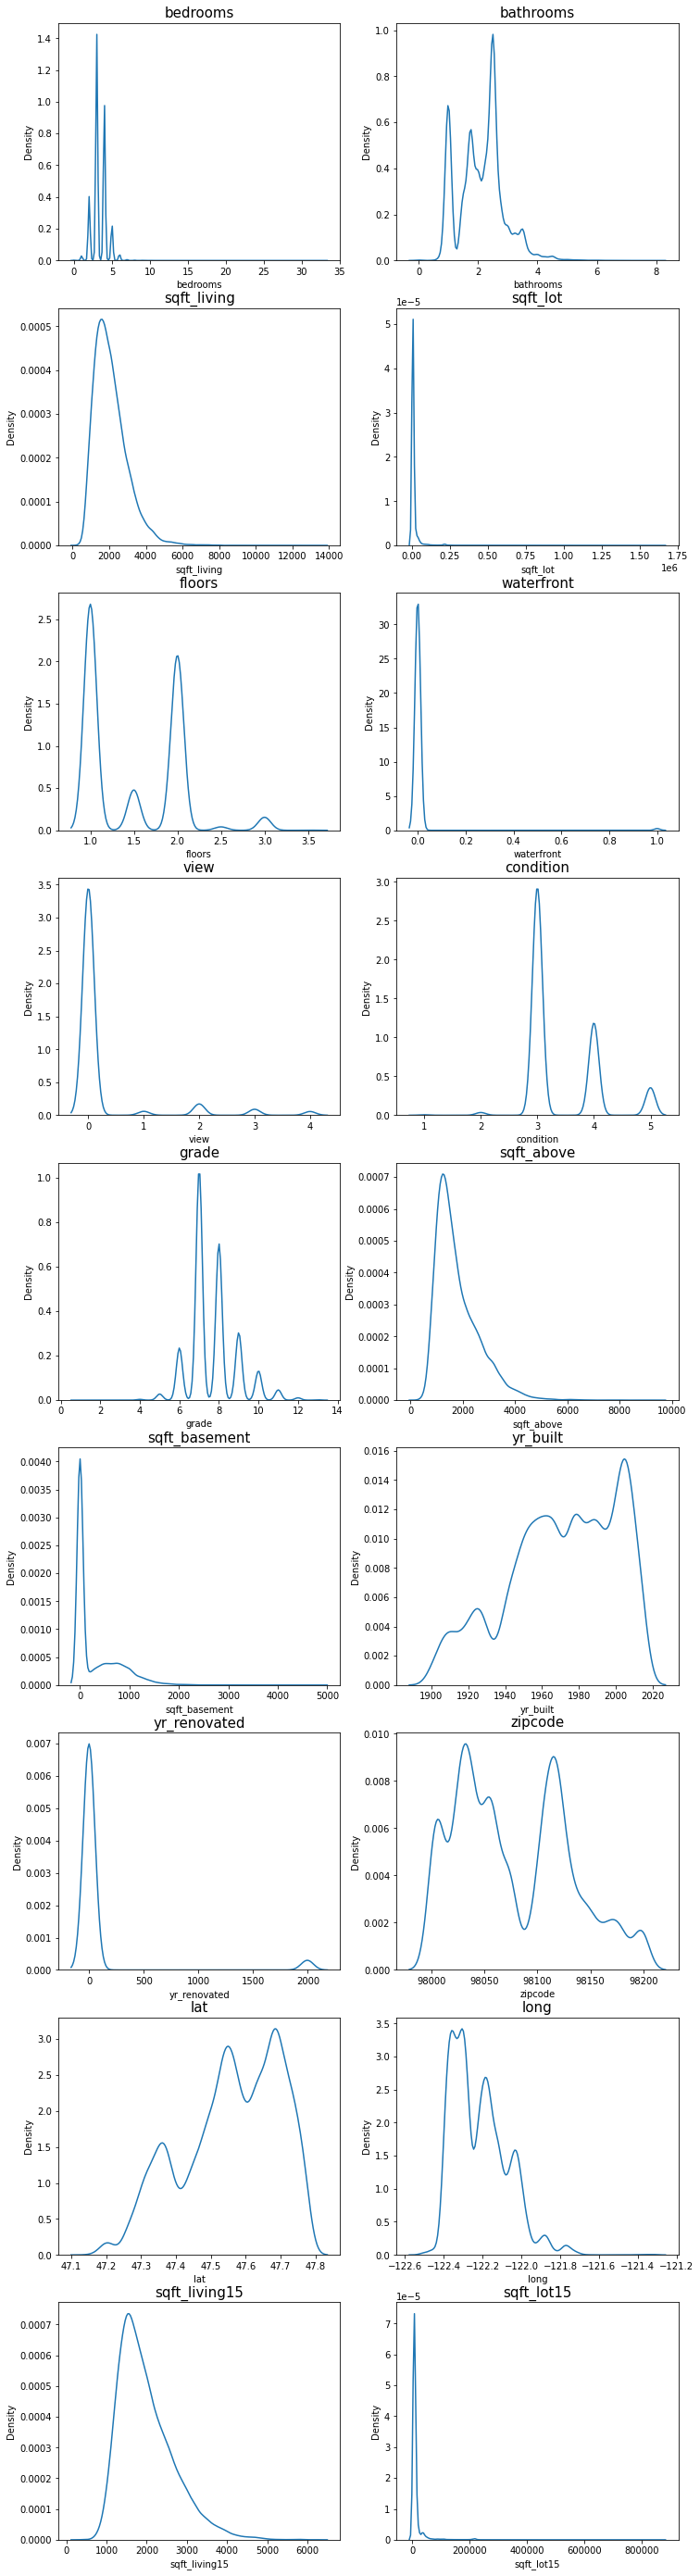

In [8]:
# 데이터 분포 시각화
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [9]:
# 분포가 치우친 컬럼 로그화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

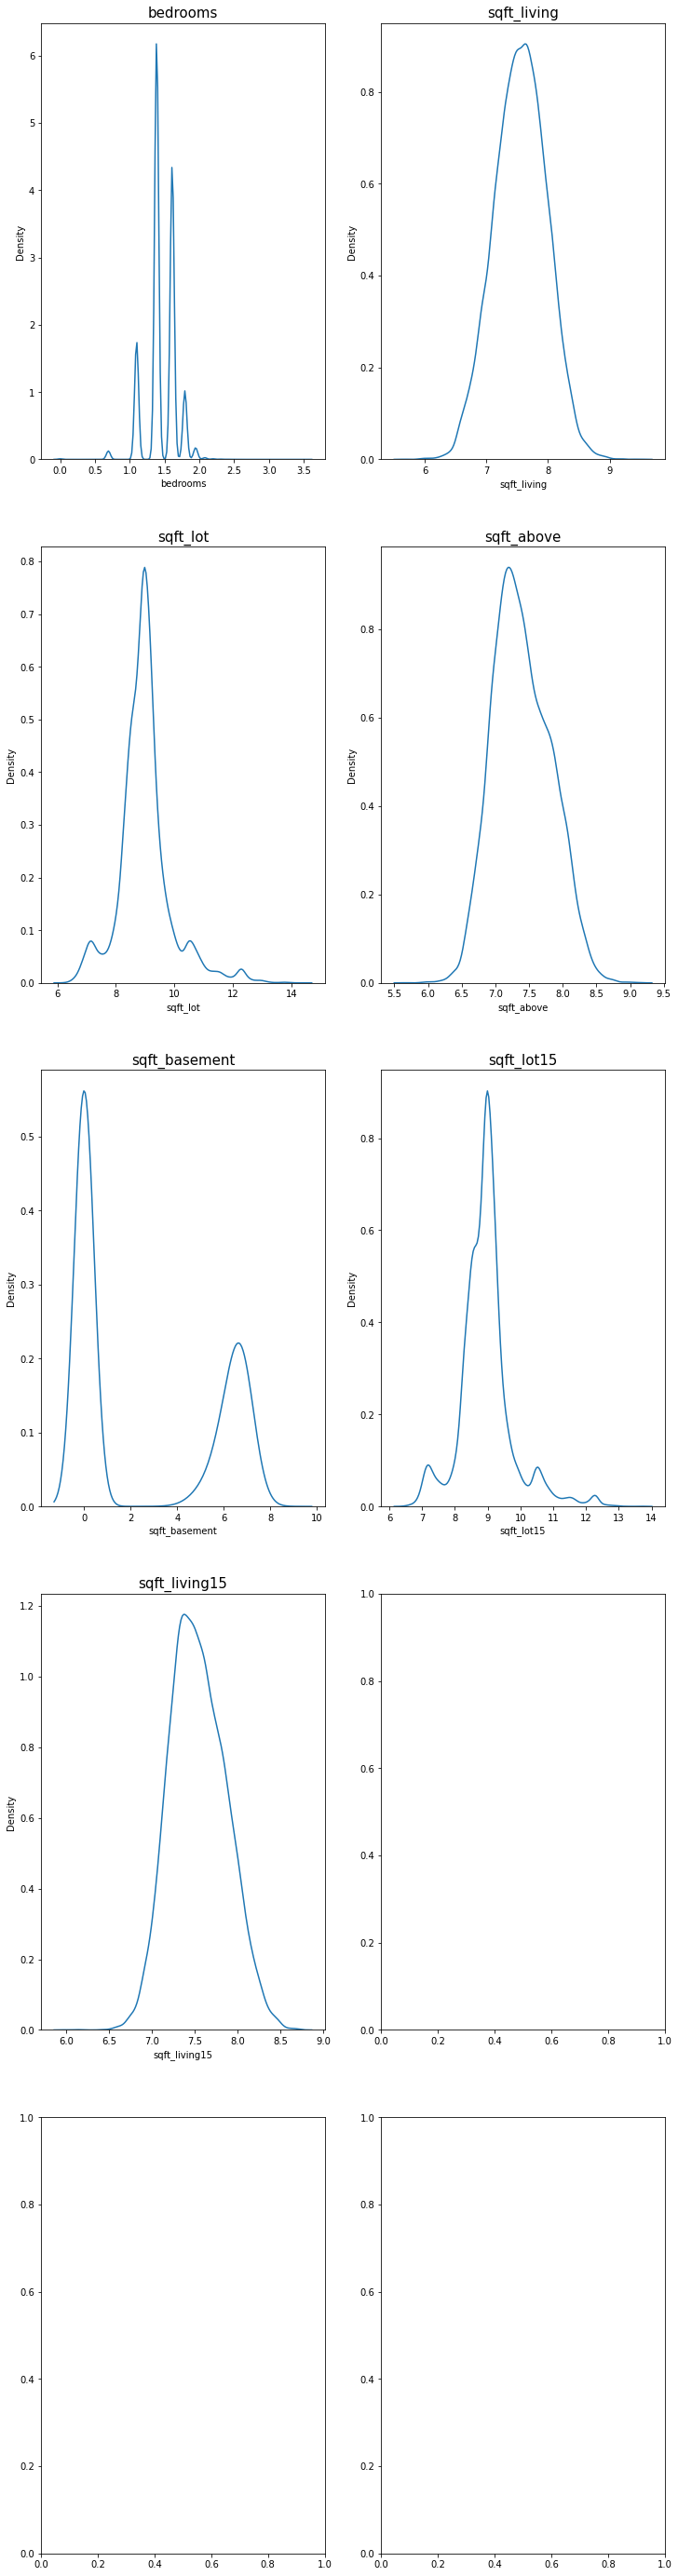

In [10]:
# 로그 후 분포 재확인
fig, ax = plt.subplots(5, 2, figsize=(12, 50))

count = 0
columns = skew_columns
for row in range(int(np.ceil(len(columns)/2))):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == len(columns) :
            break

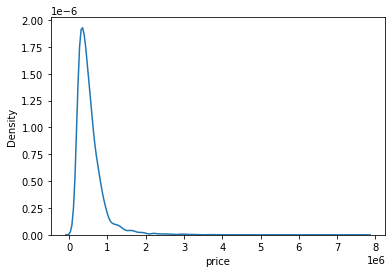

In [11]:
# y 분포 확인
sns.kdeplot(y)
plt.show()

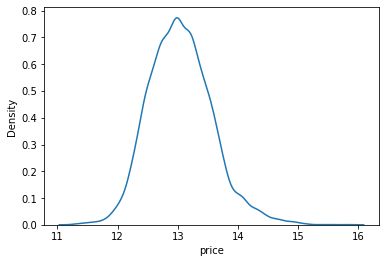

In [12]:
# y log화
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [13]:
# train, sub 분리
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [14]:
# 모델 불러오기
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [15]:
# Cross Validation
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


In [16]:
# AveragingBlending
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [17]:
# submission 데이터 확인
data_dir = './data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [18]:
# 결과 저장
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [19]:
# 결과 저장
my_submission_path = './'
result.to_csv(my_submission_path + 'submission.csv', index=False)

# 하이퍼 파라미터 튜닝

In [20]:
data_dir = './data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [21]:
# date 숫자화
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

In [22]:
# 타겟 컬럼, id 제거
y = train['price']
del train['price']
del train['id']

# test 데이터도 동일하게 수행
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

# y 로그화
y = np.log1p(y)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 로그화된 y값을 expm1으로 복원 후 rmse 계산하기
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [24]:
# 모델에 따른 스코어 계산하기
def get_scores(models, train, y):
    
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,145613.146306
GradientBoostingRegressor,140777.212290
XGBRegressor,126812.239384
LGBMRegressor,122813.622366


In [25]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        cv=5, verbose=5, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=980417), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=5)

In [26]:
# 파라미터와 스코어 데이터프레임으로 저장하가
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

results = pd.DataFrame(params)
results['score'] = score

results['RMSE'] = np.sqrt(-1 * results['score'])
results = results.rename(columns={'RMSE': 'RMSLE'})
results = results.sort_values(by='RMSLE')

results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [27]:
# GridSearchCV 과정 함수화
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [28]:
# 함수 활용하여 gridsearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

# fit & predict
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [29]:
# y 값 복원 & 저장
prediction = np.expm1(prediction)
data_dir = './data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
# print(submission_csv_path)

In [30]:
# y값 예측, 복원, 저장 함수화
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = './data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [31]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

./data/submission_lgbm_RMSLE_0.164399.csv saved!


# 예측 성능을 높여보자
- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

In [43]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [44]:
# 데이터 불러오기
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

train = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

In [45]:
# 데이터 전처리

# 타겟 피쳐 y로 저장 앤 제거
y = train['price']
del train['price']

# train, test 데이터 합치기
train_len = len(train)
train_sub_X = pd.concat((train, sub), axis=0)

# test id 저장, id 컬럼 제거
sub_id = train_sub_X['id'][train_len:]
del train_sub_X['id']

train_sub_X['date'] = pd.to_datetime(train_sub_X['date'])
train_sub_X['year'] = train_sub_X['date'].dt.year
train_sub_X['month'] = train_sub_X['date'].dt.month
train_sub_X['day'] = train_sub_X['date'].dt.day
# train_sub_X['hour'] = train_sub_X['date'].dt.hour
# train_sub_X['minute'] = train_sub_X['date'].dt.minute
# train_sub_X['second'] = train_sub_X['date'].dt.second
del train_sub_X['date']

# 분포가 치우친 컬럼 로그화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_sub_X[c] = np.log1p(train_sub_X[c].values)

sub_X = train_sub_X.iloc[train_len:, :]
train_X = train_sub_X.iloc[:train_len, :]

In [46]:
# cols = ['year', 'month', 'day', 'hour', 'minute', 'second']
# n_cols = len(cols)

# plt.figure()
# for i, col in enumerate(cols):
#     plt.subplot(3, 2, i+1)
#     sns.countplot(train_sub_X[col])

# plt.show()

train_sub_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21503 non-null  float64
 1   bathrooms      21503 non-null  float64
 2   sqft_living    21503 non-null  float64
 3   sqft_lot       21503 non-null  float64
 4   floors         21503 non-null  float64
 5   waterfront     21503 non-null  int64  
 6   view           21503 non-null  int64  
 7   condition      21503 non-null  int64  
 8   grade          21503 non-null  int64  
 9   sqft_above     21503 non-null  float64
 10  sqft_basement  21503 non-null  float64
 11  yr_built       21503 non-null  int64  
 12  yr_renovated   21503 non-null  int64  
 13  zipcode        21503 non-null  int64  
 14  lat            21503 non-null  float64
 15  long           21503 non-null  float64
 16  sqft_living15  21503 non-null  float64
 17  sqft_lot15     21503 non-null  float64
 18  year   

In [69]:
# 함수
# Cross Validation
def get_cv_score(X, y, models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=X.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

# AveragingBlending
def AveragingBlending(models, train_X, y, sub_X): # y_pred 리턴
    
    predictions = np.column_stack([
        m.predict(sub_X.values) for m in models
    ])
    return np.mean(predictions, axis=1)

# 일반 rmse 계산하기
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

# 로그화된 y값을 expm1으로 복원 후 rmse 계산하기
def rmse_expm1(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 모델에 따른 스코어 계산하기
def get_scores(models, train_X, y): # 모델명 점수 데이터프레임으로 리턴
    
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train_X, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

# GridSearchCV 과정 함수화
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5): # 데이터프레임 출력
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [48]:
# 모델링

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
# GridSearchCV - lightgbm
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 25, 50],
    'learning_rate' : [0.05, 0.1],
    'num_iterations' : [1000, 2000]    
}

lightgbm_grid_result = my_GridSearch(lightgbm, train_X, y, param_grid, verbose=2, n_jobs=5)
lightgbm_grid_result

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
1,0.05,10,50,2000,-1.605818e+10,126720.887329
3,0.05,10,100,2000,-1.605818e+10,126720.887329
5,0.05,10,150,2000,-1.605818e+10,126720.887329
22,0.10,10,150,1000,-1.611199e+10,126933.024070
20,0.10,10,100,1000,-1.611199e+10,126933.024070
18,0.10,10,50,1000,-1.611199e+10,126933.024070
0,0.05,10,50,1000,-1.613820e+10,127036.201174
2,0.05,10,100,1000,-1.613820e+10,127036.201174
4,0.05,10,150,1000,-1.613820e+10,127036.201174
15,0.05,50,100,2000,-1.614042e+10,127044.934054


In [7]:
# GridSearchCV - gboost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 25, 50],
    'learning_rate' : [0.05, 0.1]  
}

gboost_grid_result = my_GridSearch(gboost, train_X, y, param_grid, verbose=2, n_jobs=5)
gboost_grid_result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
11,0.10,10,150,-1.787179e+10,133685.420225
10,0.10,10,100,-1.788788e+10,133745.574886
2,0.05,10,150,-1.788932e+10,133750.954236
1,0.05,10,100,-1.809641e+10,134522.903790
9,0.10,10,50,-1.814925e+10,134719.152971
0,0.05,10,50,-1.998075e+10,141353.265112
3,0.05,25,50,-3.174254e+10,178164.356075
6,0.05,50,50,-3.189040e+10,178578.822958
4,0.05,25,100,-3.273980e+10,180941.439707
5,0.05,25,150,-3.287447e+10,181313.182121


In [8]:
# GridSearchCV - xgboost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 25, 50],
    'learning_rate' : [0.05, 0.1]   
}

xgboost_grid_result = my_GridSearch(xgboost, train_X, y, param_grid, verbose=2, n_jobs=5)
xgboost_grid_result

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[22:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
23,0.10,10,150,2000,-1.674924e+10,129418.843578
22,0.10,10,150,1000,-1.674924e+10,129418.843578
20,0.10,10,100,1000,-1.683529e+10,129750.870587
21,0.10,10,100,2000,-1.683529e+10,129750.870587
4,0.05,10,150,1000,-1.692532e+10,130097.342112
5,0.05,10,150,2000,-1.692532e+10,130097.342112
2,0.05,10,100,1000,-1.735718e+10,131746.653232
3,0.05,10,100,2000,-1.735718e+10,131746.653232
18,0.10,10,50,1000,-1.736164e+10,131763.592101
19,0.10,10,50,2000,-1.736164e+10,131763.592101


In [11]:
# GridSearchCV - rdforest
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [50, 100]  
}

rdforest_grid_result = my_GridSearch(rdforest, train_X, y, param_grid, verbose=2, n_jobs=5)
rdforest_grid_result

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
1,50,500,-1.778017e+10,133342.303957
3,100,500,-1.778017e+10,133342.303957
0,50,100,-1.778311e+10,133353.323282
2,100,100,-1.778311e+10,133353.323282


In [67]:
# GridSearch에 따른 하이퍼 파라미터 모델 반영

gboost = GradientBoostingRegressor(learning_rate=0.05, max_depth=10, n_estimators=50, random_state=random_state)
xgboost = XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=150, random_state=random_state)
lightgbm = LGBMRegressor(learning_rate=0.1, max_depth=10, n_estimators=150, random_state=random_state)
rdforest = RandomForestRegressor(max_depth=50, n_estimators=500, random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

# 학습 & RMSE 값 출력력
get_scores(models, train_X, y)

,RMSE
GradientBoostingRegressor,152562.581497
RandomForestRegressor,146978.944240
XGBRegressor,141255.781894
LGBMRegressor,135081.653895


In [70]:
# 평균값 계산
sub_y_pred = AveragingBlending(models, train_X, y, sub_X)
sub_y_pred

array([ 500519.19749424,  489429.34559485, 1403431.37600616, ...,
        460646.02909372,  336356.60677451,  439693.11530466])

In [72]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : sub_y_pred
})

result.head()

,id,price
0,15035,5.005192e+05
1,15036,4.894293e+05
2,15037,1.403431e+06
3,15038,3.142203e+05
4,15039,3.335186e+05


In [73]:
# 결과 저장
my_submission_path = './'
result.to_csv(my_submission_path + 'submission.csv', index=False)

# 성능높이기 2

In [75]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [76]:
# 데이터 불러오기
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

train = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

In [77]:
# 데이터 전처리

# 타겟 피쳐 y로 저장 앤 제거
y = train['price']
del train['price']

y = np.log1p(y)

# train, test 데이터 합치기
train_len = len(train)
train_sub_X = pd.concat((train, sub), axis=0)

# test id 저장, id 컬럼 제거
sub_id = train_sub_X['id'][train_len:]
del train_sub_X['id']

train_sub_X['date'] = pd.to_datetime(train_sub_X['date'])
train_sub_X['year'] = train_sub_X['date'].dt.year
train_sub_X['month'] = train_sub_X['date'].dt.month
train_sub_X['day'] = train_sub_X['date'].dt.day
# train_sub_X['hour'] = train_sub_X['date'].dt.hour
# train_sub_X['minute'] = train_sub_X['date'].dt.minute
# train_sub_X['second'] = train_sub_X['date'].dt.second
del train_sub_X['date']

# 분포가 치우친 컬럼 로그화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_sub_X[c] = np.log1p(train_sub_X[c].values)

sub_X = train_sub_X.iloc[train_len:, :]
train_X = train_sub_X.iloc[:train_len, :]

In [84]:
# 함수
# Cross Validation
def get_cv_score(X, y, models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=X.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

# AveragingBlending
def AveragingBlending(models, train_X, y, sub_X): # y_pred 리턴
    
    predictions = np.column_stack([
        m.predict(sub_X.values) for m in models
    ])
    return np.mean(predictions, axis=1)

# 일반 rmse 계산하기
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

# 로그화된 y값을 expm1으로 복원 후 rmse 계산하기
def rmse_expm1(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 모델에 따른 스코어 계산하기
def get_scores(models, train_X, y, rmse_func=rmse): # 모델명 점수 데이터프레임으로 리턴
    
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train_X, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse_func(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

# GridSearchCV 과정 함수화
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5): # 데이터프레임 출력
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [79]:
# 모델링

# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=980417

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [80]:
# GridSearchCV - lightgbm
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 25, 50],
    'learning_rate' : [0.05, 0.1]   
}

lightgbm_grid_result = my_GridSearch(lightgbm, train_X, y, param_grid, verbose=2, n_jobs=5)
lightgbm_grid_result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
17,0.10,50,150,-0.026573,0.163011
14,0.10,25,150,-0.026573,0.163011
11,0.10,10,150,-0.026596,0.163082
13,0.10,25,100,-0.027148,0.164766
16,0.10,50,100,-0.027148,0.164766
10,0.10,10,100,-0.027162,0.164808
8,0.05,50,150,-0.027544,0.165964
5,0.05,25,150,-0.027544,0.165964
2,0.05,10,150,-0.027598,0.166126
7,0.05,50,100,-0.029208,0.170902


In [81]:
# GridSearchCV - gboost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 25, 50],
    'learning_rate' : [0.05, 0.1]  
}

gboost_grid_result = my_GridSearch(gboost, train_X, y, param_grid, verbose=2, n_jobs=5)
gboost_grid_result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
2,0.05,10,150,-0.029595,0.172032
11,0.10,10,150,-0.029933,0.173013
1,0.05,10,100,-0.029959,0.173088
10,0.10,10,100,-0.029964,0.173100
9,0.10,10,50,-0.030396,0.174346
0,0.05,10,50,-0.033390,0.182730
3,0.05,25,50,-0.057061,0.238874
6,0.05,50,50,-0.058489,0.241844
4,0.05,25,100,-0.059351,0.243620
5,0.05,25,150,-0.059636,0.244206


In [82]:
# GridSearchCV - xgboost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 25, 50],
    'learning_rate' : [0.05, 0.1]   
}

xgboost_grid_result = my_GridSearch(xgboost, train_X, y, param_grid, verbose=2, n_jobs=5)
xgboost_grid_result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
11,0.10,10,150,-0.027360,0.165409
2,0.05,10,150,-0.027411,0.165563
10,0.10,10,100,-0.027538,0.165945
8,0.05,50,150,-0.028648,0.169257
17,0.10,50,150,-0.028735,0.169515
5,0.05,25,150,-0.028751,0.169562
16,0.10,50,100,-0.028783,0.169656
14,0.10,25,150,-0.028990,0.170265
13,0.10,25,100,-0.029036,0.170399
9,0.10,10,50,-0.034441,0.185584


In [83]:
# GridSearchCV - rdforest
param_grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [50, 100, 200]  
}

rdforest_grid_result = my_GridSearch(rdforest, train_X, y, param_grid, verbose=2, n_jobs=5)
rdforest_grid_result

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,max_depth,n_estimators,score,RMSLE
3,50,2000,-0.031768,0.178235
7,100,2000,-0.031768,0.178235
11,200,2000,-0.031768,0.178235
2,50,1000,-0.031779,0.178267
6,100,1000,-0.031779,0.178267
10,200,1000,-0.031779,0.178267
1,50,500,-0.031853,0.178474
5,100,500,-0.031853,0.178474
9,200,500,-0.031853,0.178474
0,50,100,-0.032143,0.179285


In [85]:
# GridSearch에 따른 하이퍼 파라미터 모델 반영

gboost = GradientBoostingRegressor(learning_rate=0.05, max_depth=10, n_estimators=150, random_state=random_state)
xgboost = XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=150, random_state=random_state)
lightgbm = LGBMRegressor(learning_rate=0.1, max_depth=50, n_estimators=150, random_state=random_state)
rdforest = RandomForestRegressor(max_depth=50, n_estimators=2000, random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

# 학습 & RMSE 값 출력력
get_scores(models, train_X, y, rmse_func=rmse_expm1)

,RMSE
RandomForestRegressor,145804.696769
GradientBoostingRegressor,143079.397194
XGBRegressor,135239.013485
LGBMRegressor,120554.003152


In [88]:
# 평균값 계산
sub_y_pred = AveragingBlending(models, train_X, y, sub_X)
sub_y_pred = np.expm1(sub_y_pred)
sub_y_pred

array([ 480386.2767428 ,  473471.19011512, 1396418.61878837, ...,
        463648.784997  ,  324670.8775589 ,  436855.12326855])

In [89]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : sub_y_pred
})

result.head()

,id,price
0,15035,4.803863e+05
1,15036,4.734712e+05
2,15037,1.396419e+06
3,15038,3.087379e+05
4,15039,3.317365e+05


In [90]:
# 결과 저장
my_submission_path = './'
result.to_csv(my_submission_path + 'submission.csv', index=False)